In [1]:
%load_ext autoreload
%autoreload 2

import sys
sys.path.insert(0, '../python/')

# Liège city dataset

In [2]:
import os
import via as VIA

from PIL import Image
from walonmap import _WALONMAP as wm
from summarize import parse

tempfolder = '../products/liege/'

os.makedirs(tempfolder, exist_ok=True)

via = VIA.load('../resources/walonmap/via_liege_city.json')

for imagename in via:
    row, col = parse(imagename)
    img = Image.open(wm.get_tile(row, col))
    img.save(os.path.join(tempfolder, imagename))

n = sum(1
    for f in os.listdir(tempfolder)
    if os.path.isfile(os.path.join(tempfolder, f))
)

print('{} tiles downloaded'.format(n))

661 tiles downloaded


In [3]:
import json
import random

from torch.utils.data import DataLoader
from dataset import VIADataset, RandomTranspose, ToTensor

keys = sorted(list(via.keys()))

random.seed(0)
random.shuffle(keys)

train_via = {key: via[key] for key in keys[:550]}
test_via = {key: via[key] for key in keys[550:]}

trainset = ToTensor(RandomTranspose(VIADataset(train_via, tempfolder, size=None, shuffle=True)))
testset = ToTensor(VIADataset(test_via, tempfolder, size=None, shuffle=True))

trainloader = DataLoader(trainset, batch_size=2)
testloader = DataLoader(testset, batch_size=5)

print('Training size = {}'.format(len(trainset)))
print('Validation size = {}'.format(len(testset)))

Training size = 550
Validation size = 111


# Model

The model used is a **Multi-Task U-Net** trained for `29` epochs on the whole californian dataset using the `MultiTaskLoss` loss function. The californian images have been up-scaled by a factor `2` to match the WalOnMap scale.

In [4]:
import torch
from models import MultiTaskUNet

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = MultiTaskUNet(3, 1, R=5).to(device)
model.load_state_dict(torch.load('../products/models/multiunet_x2_029.pth', map_location=device))

<All keys matched successfully>

## Before

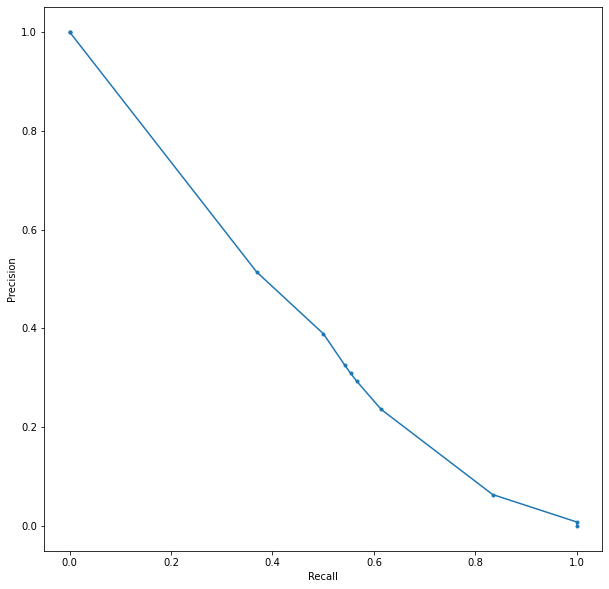

In [5]:
import matplotlib.pyplot as plt
import numpy as np
import train

from criterions import TP, TN, FP, FN

metrics = train.eval(
    model,
    testloader,
    [m(x) for m in [TP, TN, FP, FN] for x in [0, 1e-6, 1e-3, 0.1, 0.5, 0.9, 1 - 1e-3, 1 - 1e-6, 1]]
)

tp, tn, fp, fn = np.sum(metrics, axis=0).reshape((4, -1))

precision = np.zeros(len(tp) + 2)
recall = np.zeros(precision.shape)
precision[-1] = recall[0] = 1

precision[1:-1] = (tp + 1e-9) / (tp + fp + 1e-9)
recall[1:-1] = (tp + 1e-9) / (tp + fn + 1e-9)

plt.figure(figsize=(10, 10))
plt.plot(recall, precision, '.-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [6]:
average_precision = -np.trapz(x=recall, y=precision)

print('Average precision = {}'.format(average_precision))

Average precision = 0.41271328020124565


## Fine tuning

The model will be fine-tuned for `20` more epochs on `550` hand-annotated images from the WalOnMap dataset.

In [7]:
from criterions import MultiTaskLoss
from torch.optim import Adam

criterion = MultiTaskLoss(smooth=1., R=5)
optimizer = Adam(model.parameters(), lr=3e-4)

for epoch in range(20):
    losses = train.train_epoch(model, trainloader, criterion, optimizer)
    print('Epoch {} : loss = {}'.format(epoch, np.mean(losses)))

Epoch 0 : loss = 0.6215042377195575
Epoch 1 : loss = 0.5690389567342672
Epoch 2 : loss = 0.5454312912713397
Epoch 3 : loss = 0.5382358409328895
Epoch 4 : loss = 0.5207253537394784
Epoch 5 : loss = 0.5267858151143248
Epoch 6 : loss = 0.5306633585420522
Epoch 7 : loss = 0.513538854894313
Epoch 8 : loss = 0.4859554616294124
Epoch 9 : loss = 0.4924165956540541
Epoch 10 : loss = 0.4979673285782337
Epoch 11 : loss = 0.49127810205925593
Epoch 12 : loss = 0.4956167415461757
Epoch 13 : loss = 0.5039814780110663
Epoch 14 : loss = 0.4993711505559358
Epoch 15 : loss = 0.5137134096568281
Epoch 16 : loss = 0.4752931725301526
Epoch 17 : loss = 0.5048885269327598
Epoch 18 : loss = 0.49008338701995935
Epoch 19 : loss = 0.47893841708248314


In [8]:
torch.save(model.state_dict(), '../products/models/multiunet_x2_029_20.pth')

## After

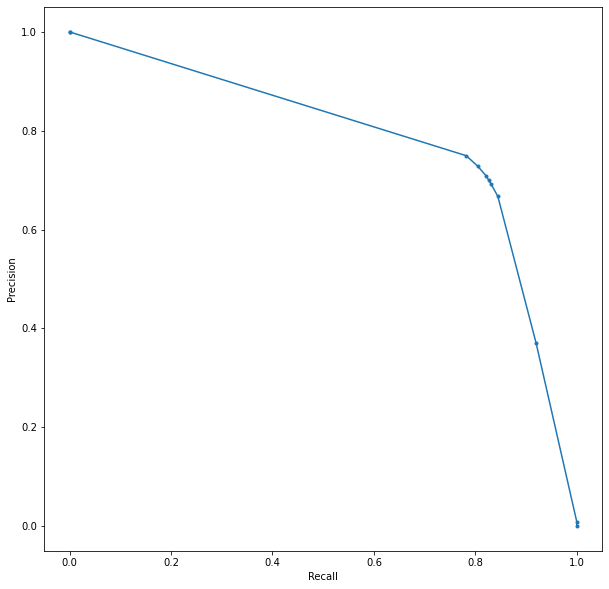

In [9]:
metrics = train.eval(
    model,
    testloader,
    [m(x) for m in [TP, TN, FP, FN] for x in [0, 1e-6, 1e-3, 0.1, 0.5, 0.9, 1 - 1e-3, 1 - 1e-6, 1]]
)

tp, tn, fp, fn = np.sum(metrics, axis=0).reshape((4, -1))

precision = np.zeros(len(tp) + 2)
recall = np.zeros(precision.shape)
precision[-1] = recall[0] = 1

precision[1:-1] = (tp + 1e-9) / (tp + fp + 1e-9)
recall[1:-1] = (tp + 1e-9) / (tp + fn + 1e-9)

plt.figure(figsize=(10, 10))
plt.plot(recall, precision, '.-')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.show()

In [10]:
average_precision = -np.trapz(x=recall, y=precision)

print('Average precision = {}'.format(average_precision))

Average precision = 0.7828909631027177


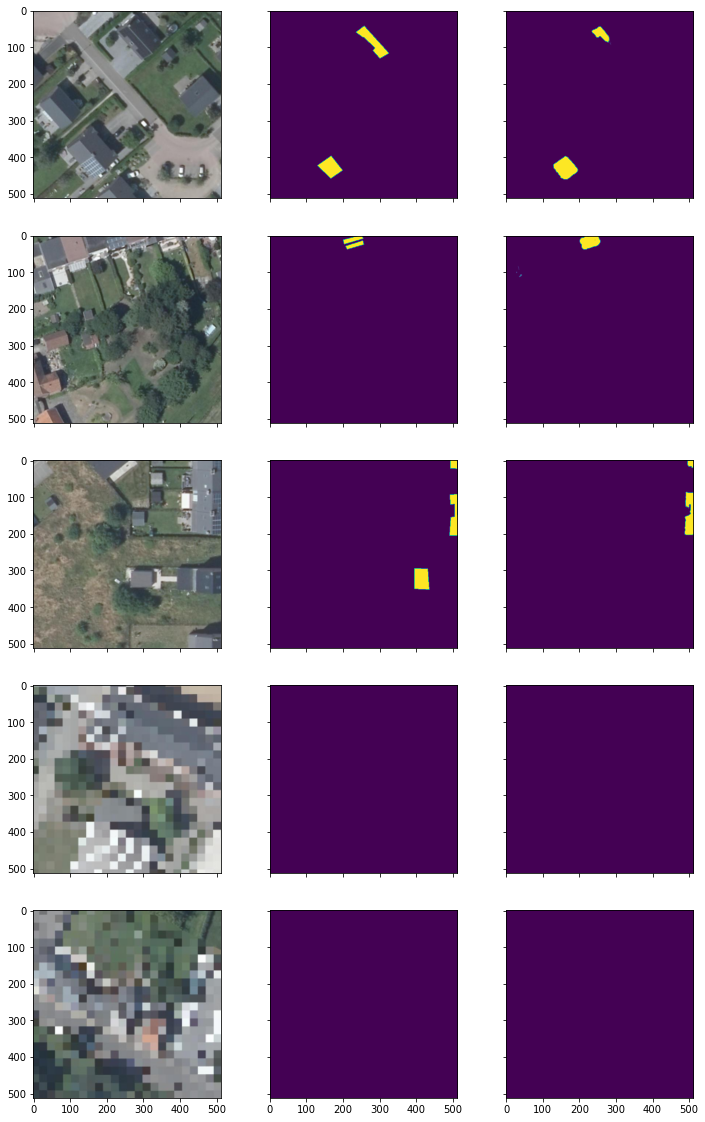

In [11]:
from dataset import to_pil
from plots import plot_alongside

model.eval()

with torch.no_grad():
    for inputs, targets in testloader:
        break

    inputs = inputs.to(device)
    outputs = model(inputs)

plot_alongside(
    map(to_pil, inputs.cpu()),
    map(to_pil, targets),
    map(to_pil, outputs.cpu())
)